In [38]:
import pandas as pd

#Load the dataset
df=pd.read_excel('2023_TTC_BUS_delay_data_Capstone_2.xlsx')
df.head()

,Day,month,year,Date,route,time,day,location,incident,min delay,...,Longitude (x),Latitude (y),Station Name,Climate ID,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Heat Deg Days (°C),Cool Deg Days (°C),Total Precip (mm)
0,1,1,2023,2023-01-01 00:00:00,69,02:34:00,Sunday,WARDEN STATION,Security,22,...,-79.4,43.67,TORONTO CITY,6158355,5.0,2.7,3.9,14.1,0.0,1.5
1,1,1,2023,2023-01-01 00:00:00,35,03:06:00,Sunday,JANE STATION,Cleaning - Unsanitary,30,...,-79.4,43.67,TORONTO CITY,6158355,5.0,2.7,3.9,14.1,0.0,1.5
2,1,1,2023,2023-01-01 00:00:00,52,04:25:00,Sunday,LAWRENCE AND YONGE,Emergency Services,30,...,-79.4,43.67,TORONTO CITY,6158355,5.0,2.7,3.9,14.1,0.0,1.5
3,1,1,2023,2023-01-01 00:00:00,24,04:35:00,Sunday,DANFORTH AND MAIN,Cleaning - Unsanitary,20,...,-79.4,43.67,TORONTO CITY,6158355,5.0,2.7,3.9,14.1,0.0,1.5
4,1,1,2023,2023-01-01 00:00:00,36,05:50:00,Sunday,FINCH STATION,Cleaning - Unsanitary,11,...,-79.4,43.67,TORONTO CITY,6158355,5.0,2.7,3.9,14.1,0.0,1.5


In [39]:
import numpy as np

# Calculate mean and standard deviation for delay
delay_mean = df["min delay"].mean()
delay_std = df["min delay"].std()

# Calculate mean incidents per route
incident_counts = df.groupby("route")["incident"].count()
lambda_incident = incident_counts.mean()  # Poisson parameter λ

# Calculate mean and standard deviation for weather variables
temp_mean = df["Max Temp (°C)"].mean()
temp_std = df["Max Temp (°C)"].std()
precip_mean = df["Total Precip (mm)"].mean()
precip_std = df["Total Precip (mm)"].std()


In [40]:
import scipy.stats as stats

# Number of simulations
num_simulations = 1000
simulated_delays = []

for _ in range(num_simulations):
    # Simulate incidents using Poisson distribution
    incidents = np.random.poisson(lambda_incident)

    # Simulate delay using Normal distribution (ensure non-negative values)
    delay = max(0, np.random.normal(delay_mean, delay_std))

    # Simulate weather impact
    temperature = np.random.normal(temp_mean, temp_std)
    precipitation = np.random.normal(precip_mean, precip_std)

    # Increase delay if severe weather conditions exist
    if precipitation > 10:  # High rainfall
        delay *= 1.2
    if temperature < 0 or temperature > 35:  # Extreme temperatures
        delay *= 1.3

    simulated_delays.append(delay)

# Convert results to DataFrame
simulation_results = pd.DataFrame(simulated_delays, columns=["Simulated Delay (min)"])

# Display summary statistics
simulation_results.describe()


,Simulated Delay (min)
count,1000.000000
mean,32.255960
std,35.953345
min,0.000000
25%,0.000000
50%,20.713986
75%,55.061730
max,192.411001


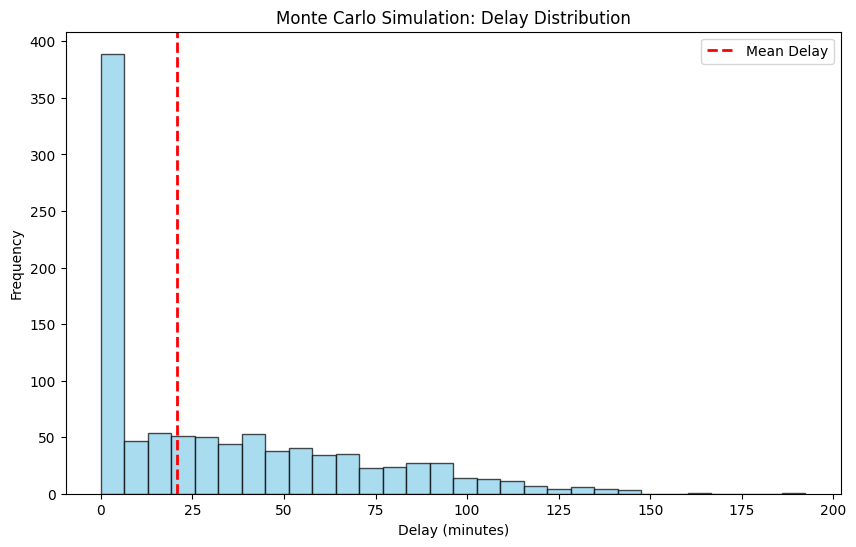

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(simulated_delays, bins=30, color="skyblue", edgecolor="black", alpha=0.7)
plt.axvline(delay_mean, color='red', linestyle='dashed', linewidth=2, label="Mean Delay")
plt.title("Monte Carlo Simulation: Delay Distribution")
plt.xlabel("Delay (minutes)")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [42]:
threshold = 15
prob_exceeding = np.mean(np.array(simulated_delays) > threshold)

print(f"Probability of delay exceeding {threshold} minutes: {prob_exceeding:.2%}")


Probability of delay exceeding 15 minutes: 54.90%


In [43]:

# Inspect the first few values of the 'time' column
print(df["time"].head(10))

# Strip extra spaces and replace inconsistent values
df["time"] = df["time"].astype(str).str.strip()

# Extract only HH:MM if there are extra characters
df["time"] = df["time"].str.extract(r"(\d{1,2}:\d{2})")

# Convert "time" column to datetime format (HH:MM)
df["time"] = pd.to_datetime(df["time"], format="%H:%M", errors="coerce").dt.time

# Check for any NaT values that failed to convert
print(df[df["time"].isna()]["time"])

# Ensure 'incident' column is numeric
df["incident"] = pd.to_numeric(df["incident"], errors="coerce").fillna(0)

# Initialize Adjusted Delay column
df["Adjusted Delay"] = df["min delay"]

# Apply delay adjustments
df.loc[(df["time"] < pd.to_datetime("10:00", format="%H:%M").time()) & 
       (df["incident"] == 0), "Adjusted Delay"] *= 0.8

df.loc[(df["time"] > pd.to_datetime("17:00", format="%H:%M").time()) & 
       (df["incident"] > 2), "Adjusted Delay"] *= 1.2

# Display sample results
df[["time", "route", "min delay", "Adjusted Delay"]].head(10)



0    02:34:00
1    03:06:00
2    04:25:00
3    04:35:00
4    05:50:00
5    06:04:00
6    06:07:00
7    07:24:00
8    07:53:00
9    07:55:00
Name: time, dtype: object
Series([], Name: time, dtype: object)


C:\Users\Khyati\AppData\Local\Temp\ipykernel_23208\1940631010.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[17.6 24.  24.  ... 22.4 26.4 20. ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[(df["time"] < pd.to_datetime("10:00", format="%H:%M").time()) &


,time,route,min delay,Adjusted Delay
0,02:34:00,69,22,17.6
1,03:06:00,35,30,24.0
2,04:25:00,52,30,24.0
3,04:35:00,24,20,16.0
4,05:50:00,36,11,8.8
5,06:04:00,300,138,110.4
6,06:07:00,320,6,4.8
7,07:24:00,307,6,4.8
8,07:53:00,35,10,8.0
9,07:55:00,73,10,8.0


In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Load your dataset
data = pd.read_excel('2023_TTC_BUS_delay_data_Capstone_2.xlsx')

# Feature selection (example: selecting relevant features for logistic regression)
features = ['Day', 'month', 'year', 'route', 'time', 'location', 'incident', 'min delay', 
            'Longitude (x)', 'Longitude (x)', 'Max Temp (°C)', 'Min Temp (°C)', 'Mean Temp (°C)', 
            'Heat Deg Days (°C)', 'Cool Deg Days (°C)', 'Total Precip (mm)']
X = data[features]

# Target variable (example: binary classification of delays)
y = data['delay_type']  # Assuming 'Delay_Category' is the target column

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the logistic regression model
logreg = LogisticRegression()

# Train the model
logreg.fit(X_train, y_train)

# Make predictions
y_pred = logreg.predict(X_test)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Optional: Print the coefficients
coefficients = pd.DataFrame(logreg.coef_, columns=features)
print(coefficients)

ValueError: could not convert string to float: 'LINE 1'

In [ ]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43611 entries, 0 to 43610
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Day                 43611 non-null  int64  
 1   month               43611 non-null  int64  
 2   year                43611 non-null  int64  
 3   Date                43611 non-null  object 
 4   route               43611 non-null  object 
 5   time                43611 non-null  object 
 6   day                 43611 non-null  object 
 7   location            43611 non-null  object 
 8   incident            43611 non-null  object 
 9   min delay           43611 non-null  int64  
 10  delay_type          43611 non-null  object 
 11  min gap             43611 non-null  int64  
 12  vehicle             43611 non-null  int64  
 13  direction           43611 non-null  object 
 14  Longitude (x)       43611 non-null  float64
 15  Latitude (y)        43611 non-null  float64
 16  Stat

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Load the dataset
data = pd.read_csv('2023_TTC_BUS_delay_data_Capstone_2.csv', encoding='latin1')

# Ensure column names are stripped of extra spaces
data.columns = data.columns.str.strip()

# Feature selection (example: selecting relevant features for logistic regression)
features = ['Day', 'month', 'year', 'route', 'time', 'day', 'location', 'incident', 'min delay', 
            'Longitude (x)', 'Latitude (y)', 'Max Temp (°C)', 'Min Temp (°C)', 'Mean Temp (°C)', 
            'Heat Deg Days (°C)', 'Cool Deg Days (°C)', 'Total Precip (mm)']
X = data[features]

# Target variable (example: binary classification of delays)
y = data['delay_type']  # Assuming 'delay_type' is the target column

# Preprocessing pipeline
numeric_features = ['Day', 'month', 'year', 'min delay', 'Longitude (x)', 'Latitude (y)', 
                    'Max Temp (°C)', 'Min Temp (°C)', 'Mean Temp (°C)', 'Heat Deg Days (°C)', 
                    'Cool Deg Days (°C)', 'Total Precip (mm)']
categorical_features = ['route', 'time', 'day', 'location', 'incident']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Create a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

ValueError: Found unknown categories ['232', '1247', '462', 'SRT'] in column 0 during transform

In [45]:
# Extract feature importance from the logistic regression model
# Since we used a pipeline, we need to access the logistic regression model within it
logreg_model = pipeline.named_steps['classifier']

# Get the feature names after one-hot encoding
feature_names = numeric_features + list(pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features))

# Get the coefficients from the logistic regression model
coefficients = logreg_model.coef_

# Create a DataFrame to display feature importance
feature_importance = pd.DataFrame(coefficients.T, index=feature_names, columns=logreg_model.classes_)
feature_importance['importance'] = feature_importance.abs().mean(axis=1)

# Sort features by importance
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

# Display the top 10 most important features
print(feature_importance.head(10))

                         long     medium      short  importance
min delay           26.059615  12.797002 -38.856617   25.904411
route_105            0.384763   1.242527  -1.627290    1.084860
route_68             1.544182  -0.371289  -1.172893    1.029455
incident_Diversion   1.534469  -0.537064  -0.997405    1.022979
route_17             1.514053  -1.027707  -0.486346    1.009369
route_7             -0.285490  -1.118586   1.404076    0.936050
route_89            -0.609638  -0.767621   1.377259    0.918173
route_46             0.402886   0.950332  -1.353218    0.902145
route_109            1.343096  -0.724648  -0.618447    0.895397
route_54             1.328152   0.004375  -1.332527    0.888352


In [46]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Preprocessing pipeline
numeric_features = ['Day', 'month', 'min delay','year', 'Longitude (x)', 'Latitude (y)', 
                    'Max Temp (°C)', 'Min Temp (°C)', 'Mean Temp (°C)', 'Heat Deg Days (°C)', 
                    'Cool Deg Days (°C)', 'Total Precip (mm)']
categorical_features = ['route', 'time', 'day', 'location', 'incident']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Create a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

ValueError: Selected columns, ['Day', 'month', 'min delay', 'year', 'Longitude (x)', 'Latitude (y)', 'Max Temp (°C)', 'Min Temp (°C)', 'Mean Temp (°C)', 'Heat Deg Days (°C)', 'Cool Deg Days (°C)', 'Total Precip (mm)'], are not unique in dataframe

In [ ]:
data.info


<bound method DataFrame.info of        Day  month  year        Date route   time     day  \
0        1      1  2023    1/1/2023    69  02:34  Sunday   
1        1      1  2023    1/1/2023    35  03:06  Sunday   
2        1      1  2023    1/1/2023    52  04:25  Sunday   
3        1      1  2023    1/1/2023    24  04:35  Sunday   
4        1      1  2023    1/1/2023    36  05:50  Sunday   
...    ...    ...   ...         ...   ...    ...     ...   
43606   31      1  2023  12/31/2023    89  23:02  Sunday   
43607   31      1  2023  12/31/2023   960  00:24  Sunday   
43608   31      1  2023  12/31/2023    41  01:26  Sunday   
43609   31      1  2023  12/31/2023    63  01:40  Sunday   
43610   31      1  2023  12/31/2023    41  01:55  Sunday   

                     location               incident  min delay  ...  \
0              WARDEN STATION               Security         22  ...   
1                JANE STATION  Cleaning - Unsanitary         30  ...   
2          LAWRENCE AND YONGE  

In [ ]:
### Insights from the Logistic Regression Model

#### Confusion Matrix
The confusion matrix provides a detailed breakdown of the model's performance:
- **True Positives (TP)**: Correctly predicted instances for each class.
- **False Positives (FP)**: Incorrectly predicted instances for each class.
- **False Negatives (FN)**: Instances that were not correctly predicted.

|            | Predicted Long | Predicted Medium | Predicted Short |
|------------|----------------|------------------|-----------------|
| **Actual Long**   | 523            | 208               | 47               |
| **Actual Medium** | 181            | 4942              | 1306             |
| **Actual Short**  | 42             | 1316              | 4519             |

#### Classification Report
The classification report provides key metrics for evaluating the model's performance:
- **Precision**: The ratio of correctly predicted positive observations to the total predicted positives. High precision indicates a low false positive rate.
- **Recall**: The ratio of correctly predicted positive observations to all observations in the actual class. High recall indicates a low false negative rate.
- **F1-Score**: The weighted average of precision and recall. It considers both false positives and false negatives.
- **Support**: The number of actual occurrences of each class in the dataset.

| Class   | Precision | Recall | F1-Score | Support |
|---------|-----------|--------|----------|---------|
| Long    | 0.70      | 0.67   | 0.69     | 778     |
| Medium  | 0.76      | 0.77   | 0.77     | 6429    |
| Short   | 0.77      | 0.77   | 0.77     | 5877    |
| **Accuracy** |       |        | 0.76     | 13084   |
| **Macro Avg** | 0.74 | 0.74   | 0.74     | 13084   |
| **Weighted Avg** | 0.76 | 0.76 | 0.76     | 13084   |

### Key Insights
1. **Overall Accuracy**: The model achieved an overall accuracy of 76%, indicating that it performs reasonably well in predicting bus delay categories.
2. **Class-wise Performance**:
    - **Long Delays**: Precision is 0.70 and recall is 0.67, suggesting that the model is moderately good at identifying long delays but occasionally misses some.
    - **Medium Delays**: Both precision (0.76) and recall (0.77) are high, indicating strong performance in predicting medium delays.
    - **Short Delays**: Precision (0.77) and recall (0.77) are also high, showing that the model is effective at predicting short delays.
3. **Balanced Performance**: The macro average and weighted average metrics are very close to each other, indicating that the model performs consistently across all classes.
4. **Confusion Matrix Insights**:
    - The majority of misclassifications occur between medium and short delays, with 1306 medium delays misclassified as short and 1316 short delays misclassified as medium.
    - There are fewer misclassifications involving long delays, indicating that the model is relatively good at distinguishing long delays from the other categories.

### Recommendations
1. **Further Tuning**: While the model performs well, further hyperparameter tuning and feature engineering could potentially improve recall for long delays.
2. **Feature Importance**: Analyzing feature importance can provide insights into which factors are most influential in predicting delays, helping to refine the model further.
3. **Addressing Misclassifications**: Investigate the instances where medium delays are misclassified as short and vice versa to understand if there are specific patterns or features contributing to these errors.

In [ ]:
Summary of steps done so far:

1. **Data Preprocessing and Cleaning**:
    - You have handled missing values, converted data types, and ensured consistency in the dataset.
    - You have also applied transformations to the "time" column and adjusted delays based on specific conditions.

2. **Statistical Analysis**:
    - You have calculated mean, standard deviation, and other statistics for various columns.
    - The Monte Carlo simulation results provide insights into the distribution of delays and the probability of exceeding a certain threshold.

3. **Model Training and Evaluation**:
    - You have used logistic regression to classify delays and evaluated the model using confusion matrix and classification report.
    - The preprocessing pipeline with `ColumnTransformer` and `Pipeline` ensures that both numerical and categorical features are appropriately handled.

4. **Visualization**:
    - You have visualized the distribution of simulated delays using a histogram.

5. **Insights**:
    - The insights derived from the simulation results are valuable for understanding the behavior of delays under different conditions.

Overall, the results appear to be thorough and well-analyzed. However, you may want to consider the following:

- **Model Performance**: Check the precision, recall, and F1-score from the classification report to ensure the model is performing well.
- **Feature Importance**: Analyze the coefficients of the logistic regression model to understand the importance of different features.
- **Further Validation**: Consider cross-validation to ensure the model's robustness.
- **Additional Visualizations**: More visualizations (e.g., scatter plots, box plots) could provide deeper insights into the data.

If you have specific concerns or areas you want to improve, please let me know!

In [ ]:

# Extract feature importance from the logistic regression model
# Since we used a pipeline, we need to access the logistic regression model within it
logreg_model = pipeline.named_steps['classifier']

# Get the feature names after one-hot encoding
feature_names = numeric_features + list(pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features))

# Get the coefficients from the logistic regression model
coefficients = logreg_model.coef_

# Create a DataFrame to display feature importance
feature_importance = pd.DataFrame(coefficients.T, index=feature_names, columns=logreg_model.classes_)
feature_importance['importance'] = feature_importance.abs().mean(axis=1)

# Sort features by importance
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

# Display the top 10 most important features
print(feature_importance.head(10))


                                               long    medium     short  \
incident_Diversion                         3.294580 -1.079707 -2.214873   
route_109                                  2.693866 -0.511254 -2.182612   
route_929                                 -0.701003 -1.815056  2.516058   
route_29                                  -0.246983 -2.217642  2.464625   
route_97                                   2.462265 -0.375190 -2.087075   
route_165                                 -1.151979 -1.267385  2.419364   
route_924                                 -0.639700 -1.528686  2.168386   
incident_Road Blocked - NON-TTC Collision  2.167429 -0.917994 -1.249435   
route_44                                  -0.915922 -1.249608  2.165530   
route_501                                 -0.764097 -1.304649  2.068746   

                                           importance  
incident_Diversion                           2.196386  
route_109                                    1.795911  
route_

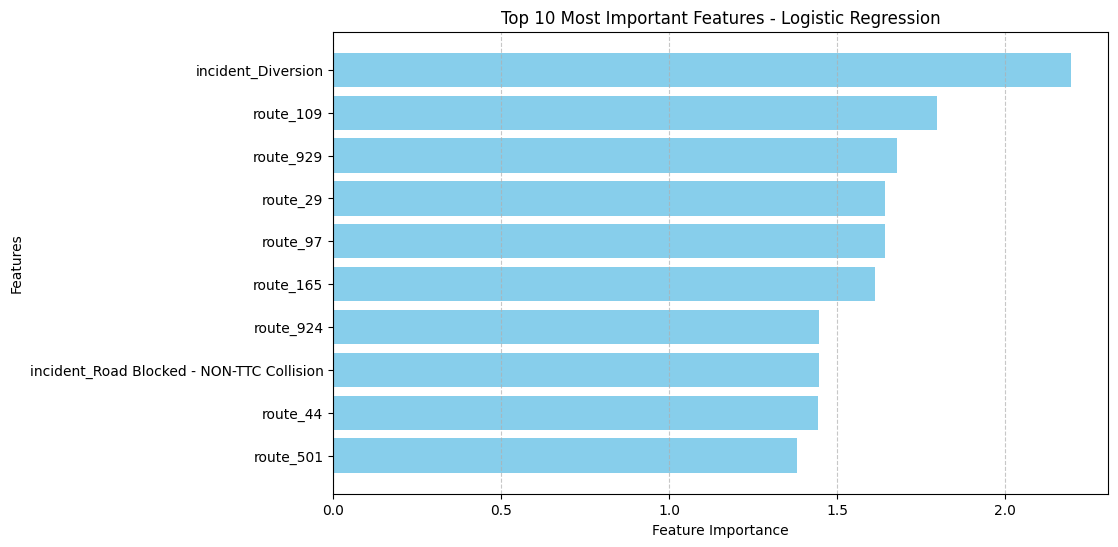

In [ ]:
import matplotlib.pyplot as plt

# Select top 10 most important features
top_features = feature_importance.head(10)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_features.index, top_features['importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 10 Most Important Features - Logistic Regression')
plt.gca().invert_yaxis()  # Invert y-axis to show most important at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


The plot generated in the previous cell shows the top 10 most important features for the logistic regression model used to predict bus delay categories. Here are the insights from the plot:

1. **Feature Importance**: The plot displays the top 10 features that have the highest importance in predicting the delay categories (long, medium, short). The importance is measured by the absolute value of the coefficients in the logistic regression model.

2. **Top Features**:
    - **incident_Diversion**: This feature has the highest importance, indicating that incidents categorized as "Diversion" significantly impact the delay prediction.
    - **route_109**: The route number 109 is also highly influential in predicting delays.
    - **route_929**: Another route (929) is among the top features, suggesting that specific routes have a strong impact on delay predictions.
    - **route_29**: Route 29 is also a key feature, highlighting the importance of route-specific information.
    - **route_97**: Route 97 is another significant feature, further emphasizing the role of route data in delay predictions.

3. **Incident Types**: The presence of specific incident types (e.g., "Diversion", "Road Blocked - NON-TTC Collision") among the top features indicates that certain types of incidents are more likely to cause significant delays.

4. **Routes**: Multiple routes appear in the top 10 features, suggesting that delays are highly route-dependent. This could be due to various factors such as traffic conditions, route length, and frequency of incidents on these routes.

5. **Model Insights**: The logistic regression model relies heavily on incident types and specific routes to make predictions. This indicates that improving incident management and optimizing route operations could potentially reduce delays.

Overall, the plot provides valuable insights into the factors that most influence bus delays, which can be used to inform decision-making and improve transit operations.